In [15]:
#%%
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
#import data
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/datadrivenH2O/train.csv')
target = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/datadrivenH2O/target.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/datadrivenH2O/test.csv')
colnames = train.columns
train.head(10)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,6/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
5,9944,20.0,13/03/2011,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe
6,19816,0.0,1/10/2012,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,54551,0.0,9/10/2012,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
8,53934,0.0,3/11/2012,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump
9,46144,0.0,3/08/2011,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [21]:
#look at train / test shapes
train.shape
train_shape = train.shape[0]
#(59400,40)
print(test.shape)
#(14850,40)
print(target.shape)

(14850, 40)
(59400, 2)


In [23]:
#look at the value_counts of the target variable
target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [24]:
#LabelEncode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target['status_group'] = le.fit_transform(target['status_group'])

In [25]:
#look at correlations of variables with target
#check for correlation between target and predictors
target_corr = list()

for c, v in enumerate(train, start = 1):
    target_corr.append(target.corrwith(train[v], method = 'spearman'))
    
target_corr = pd.Series(data = target_corr, index = train.columns, name = 'correlation')
target_corr = abs(target_corr)

In [26]:
#combine data
combine = pd.concat([train, test],  axis = 0).reset_index(drop = True)

In [27]:
#look for missing values
miss_vals = pd.Series(combine.isnull().sum(), name = 'PctMissing')
miss_vals = miss_vals[miss_vals!=0]
miss_vals = miss_vals.sort_values(ascending = False)
print(miss_vals)

scheme_name          35258
scheme_management     4846
installer             4532
funder                4504
public_meeting        4155
permit                3793
subvillage             470
Name: PctMissing, dtype: int64


In [28]:
#pct missing
miss_vals / len (combine)

scheme_name          0.474855
scheme_management    0.065266
installer            0.061037
funder               0.060660
public_meeting       0.055960
permit               0.051084
subvillage           0.006330
Name: PctMissing, dtype: float64

In [29]:
#these variables all seem to be about area / region. Might be best to use the mode of the region they're in
combine['subvillage'] = combine.groupby('region')['subvillage'].transform(lambda x:x.fillna(x.mode()[0]))
combine['public_meeting'] = combine.groupby('region')['public_meeting'].transform(lambda x:x.fillna(x.mode()[0]))
combine['permit'] = combine.groupby('region')['permit'].transform(lambda x:x.fillna(x.mode()[0]))
combine['funder'] = combine.groupby('region')['funder'].transform(lambda x:x.fillna(x.mode()[0]))
combine['installer'] = combine.groupby('region')['funder'].transform(lambda x:x.fillna(x.mode()[0]))
combine['scheme_management'] = combine.groupby('region')['scheme_management'].transform(lambda x:x.fillna(x.mode()[0]))

In [30]:
#scheme_management and scheme_name seem to be redundant. Lots of missing values for scheme_name. Will delete.
combine = combine.drop(['scheme_name'], axis = 1)

In [31]:
#check missing values
miss_vals = pd.Series(combine.isnull().sum(), name = 'PctMissing')
miss_vals = miss_vals[miss_vals!=0]
miss_vals = miss_vals.sort_values(ascending = False)
print(miss_vals)

Series([], Name: PctMissing, dtype: int64)


In [32]:
dtyp = pd.Series(combine.dtypes, name = 'dtype')

In [33]:
#some items as int are actually objects
combine['construction_year'] = combine['construction_year'].astype('object')

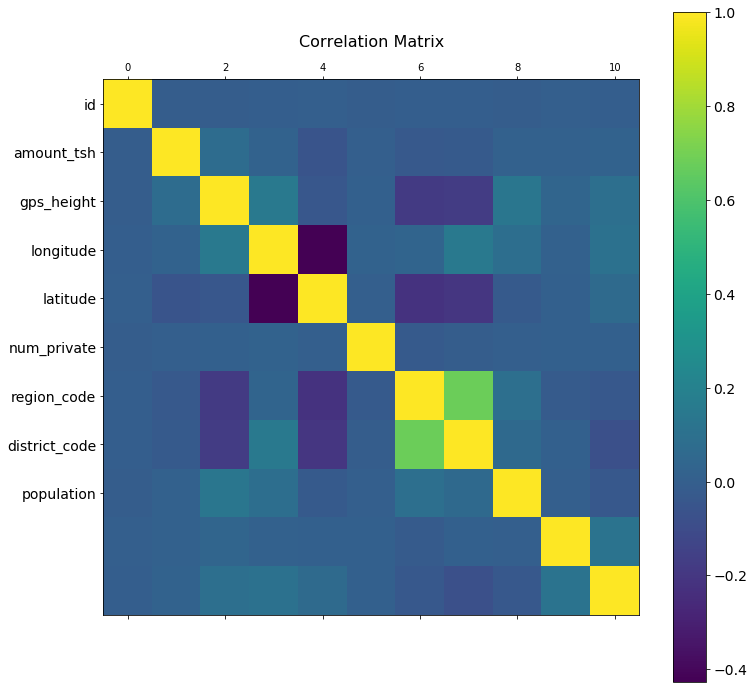

In [41]:
#check correlations between variables. See if there's some that can be deleted
f = plt.figure(figsize=(12, 12))
plt.matshow(combine.corr(), fignum=f.number)
plt.yticks(range(combine.select_dtypes(['number']).shape[1]), combine.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


In [36]:
corr_df = combine.corr()
corr_df

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit
id,1.000000,-0.007150,-0.003227,-0.001745,0.003296,-0.004497,-0.001930,-0.002566,-0.005442,0.003333,-0.001608
amount_tsh,-0.007150,1.000000,0.079851,0.023048,-0.055923,0.005384,-0.027122,-0.024201,0.018385,0.015814,0.023935
gps_height,-0.003227,0.079851,1.000000,0.149071,-0.037621,0.008042,-0.182366,-0.170897,0.134373,0.036129,0.093831
longitude,-0.001745,0.023048,0.149071,1.000000,-0.426643,0.024640,0.032260,0.150908,0.087439,0.018330,0.103673
latitude,0.003296,-0.055923,-0.037621,-0.426643,1.000000,0.006086,-0.217501,-0.200048,-0.022534,0.008831,0.068677
num_private,-0.004497,0.005384,0.008042,0.024640,0.006086,1.000000,-0.021277,-0.005264,0.003449,0.009298,0.010496
region_code,-0.001930,-0.027122,-0.182366,0.032260,-0.217501,-0.021277,1.000000,0.680393,0.094665,-0.016458,-0.033979
district_code,-0.002566,-0.024201,-0.170897,0.150908,-0.200048,-0.005264,0.680393,1.000000,0.062749,0.010103,-0.080133
population,-0.005442,0.018385,0.134373,0.087439,-0.022534,0.003449,0.094665,0.062749,1.000000,0.003161,-0.036165
public_meeting,0.003333,0.015814,0.036129,0.018330,0.008831,0.009298,-0.016458,0.010103,0.003161,1.000000,0.116957


In [38]:
#correlations are all very low. 
corr_target = combine.corrwith(target)
corr_target

id                1.0
amount_tsh        NaN
district_code     NaN
gps_height        NaN
latitude          NaN
longitude         NaN
num_private       NaN
permit            NaN
population        NaN
public_meeting    NaN
region_code       NaN
status_group      NaN
dtype: float64